## Epoching Data and Producing Averaged Wave Data
We will also include a dataframe with densities split on brainwave type

In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import signal
import scipy.fftpack
import statsmodels.api as sm

### Global Variables

In [2]:
sampling_rate = 512.0
epoch_length = 7.0

step = 100
maxamp = 750000
wavemax = int(maxamp/step)

### Helper Functions
#### Functions for Epoching Data

In [3]:
#
# Cleans a given raw openvibe dataframe
#
def clean_trial(trial):
    
    #drop unwanted columns
    trial = trial.drop(columns=['Event Duration'])
    trial = trial.drop(columns=['Event Date'])
    trial = trial.drop(columns=['Electrode'])
    
    #remove nans and key releases
    trial.loc[trial['Event Id'] == 33024,  'Event Id'] = 0
    trial.loc[trial['Event Id'].isnull(),  'Event Id'] = 0
    
    #shift df to start on start key press
    start_index = trial.index[trial['Event Id'] == 33025]
    trial = trial[(start_index[0]+1):].reset_index()
    trial = trial.drop(columns=['index'])
    
    #reset epoch to begin at 0/drop epoch column
    #trial = trial.drop(columns=['Epoch'])
    trial['Epoch']-=trial['Epoch'][0]
    
    #reset time to begin at 0
    trial['Time:512Hz']-=trial['Time:512Hz'][0]
    
    #set found waldo id 1
    trial.loc[trial['Event Id'] == 33027,  'Event Id'] = 1
    
    #rename columns as needed
    trial = trial.rename(columns={"Time:512Hz": "Time", "Event Id": "Event"})
    
    #cut end of data
    found_times = trial.loc[trial['Event'] == 1,'Time'].tolist()
    
    end_index = trial.index[trial['Time'] == found_times[len(found_times)-1]][0]
    trial = trial[0:end_index+1]
    
    
    return trial

In [4]:
#
# Reads and cleans the csv file at the given filepath
#
def processcsv(filename):
    raw = pd.read_csv(filename)
    clean = clean_trial(raw)
    return clean

In [5]:
#
# For/If we need to filter
#
def custom_filter(trial):
    print("Filter not implemented yet")

In [6]:
#
# Takes in the cleaned up data and returns an array.
# Each entry of the array has a pandas dataframe corresponding to a trial,
# Where a trial ends the moment the 'found' key was pressed. 
# At that time the next stage begins
#
def split_trials(trial):
    
    final_split = []
    found_times = trial.loc[trial['Event'] == 1,'Time'].tolist()
    
    start = 0;
    end = found_times[0]
    
    for i in range(0,len(found_times)):
        
        start_index = trial.index[trial['Time'] == start][0]
        end_index = trial.index[trial['Time'] == end][0]
        
        curr_trial = trial.loc[start_index+1:end_index+1].reset_index()     #changed this line
        curr_trial = curr_trial.drop(columns=['index'])
        curr_trial['Time']-=curr_trial['Time'][0]
        
        final_split.append(curr_trial.copy())
        
        start = end;
        if(i<len(found_times)-1):
            end = found_times[i+1]
        
    return final_split

In [7]:
#
# Takes in a trial and completes the 'Epoch' column, starting at the 'start_epoch' parameter
# This parameter is default at 0, so the trial will start at epoch 0 and so on.
# Every epoch is of length 'epoch_length', defined at the top of the notebook
# The epoch corresponding to the found stage has its 'Event' column set to 1 (facilitates extraction)
#
def single_epoch(trial, start_epoch):
    
    end_time = trial['Time'][len(trial)-1]
    start_time = trial['Time'][0]
    #print(end_time)
    #print(start_time)
    num_epochs = int((end_time-start_time)/epoch_length)
    
    #print(num_epochs)
    
    event_epoch = start_epoch + num_epochs -1
    last_epoch =  start_epoch + num_epochs -1
    trial.loc[trial['Time'] <= (end_time),'Epoch'] = last_epoch
    last_epoch-=1
    
        
    limit = end_time - epoch_length
    if limit >= epoch_length:
        while(limit >= 0):
            trial.loc[trial['Time'] < (limit),'Epoch'] = last_epoch
            last_epoch-=1
            limit -= epoch_length
        
        limit += epoch_length
    
    trial = trial[trial['Time'] > limit]
    trial.loc[trial['Epoch'] == event_epoch,'Event'] = 1
    trial = trial.reset_index()
    trial = trial.drop(columns=['index'])
    
    trial['Time']-=trial['Time'][0]
    
    return trial

In [8]:
#
# Takes in all trials and epochs them with the 'single_epoch' function
#
def epoch_trials(all_trials):
    for i in range(0,len(all_trials)):
        all_trials[i] = single_epoch(all_trials[i], 0)
    return all_trials

In [9]:
#
# Reduce dataframe to just brainwave cols
# Returns a dataframe with just the brainwave values out of a trial
#
def get_brainwaves(trial):
    return trial.drop(columns=['Time','Attention','Epoch', 'Meditation', 'Event'])

#### Functions for Averaging Brainwave Densities

In [10]:
def average_densities(raw_df):
    '''
    Generate average densities of amplitudes across brainwave types. Also stack densities of each brainwave into density_matrix.
    
    Params:
    raw_df(DataFrame): Raw brainwave values (amplitudes)
    max_amp(int): Max amplitude to calculate densities up to
    
    Returns:
    mean_vector(ndarray): 1x(maxamp/step) vector. Index represents given amplitude, value represents density of given amplitude.
    density_matrix(ndarray) : 8x(maxamp/step) matrix. 
                              density_matrix(i,j) == density of amplitude j within brainwave type i
    '''

    # matrix to contain all densities
    # let rows == wave type, columns == pdf generated density Y at X amplitude (for given wave)
    density_matrix = np.empty([8,int(wavemax)])

    # iterate across all wave types and stack each wave type density as rows in density_matrix
    # wave type density is a 75,000 value list. each value represents the density of waves at [index] frequency
    for i in range(0, raw_df.shape[1]):
        print("Calculating density for wave " + str(i+1) + "/8")
        # potential optimization: clear repeating values in original df
        density = stats.gaussian_kde(raw_df.iloc[0:,i], bw_method='scott')
        density_matrix[i] = list(density.pdf(range(0,maxamp,step)))     # potential optimization: increase step width

    # now find the total average densities for all wave types, 
    # column wise (end with 1x75000 vector) that reprents overall behavior
    mean_vector = np.mean(density_matrix, axis=0)
    
    return mean_vector, density_matrix

In [11]:
def plot_avg(mean_vectors, labels, title, x_max=17000, fig_x=14, fig_y=8):
    '''
    Plot mean density of each amplitude. Not trivial because average_densities compresses the original densities by a factor of
    step.
    
    Params:
    mean_vector(ndarray): 1x(maxamp/step) vector. Index represents given amplitude, value represents density of given amplitude.
    x_max(int): Max value to show on plot x-axis.
    fig_x(int): X dimension of figure generated
    fig_y(int): Y dimension of figure generated
    '''
    
    #generate plot
    plt.figure(figsize=(fig_x,fig_y))
        
    i = 0
    for v in mean_vectors:
    
        # must create accurate x-axis vector (stretch by factor of step)
        x_axis = list(range(0,wavemax))
        x_axis = [x * step for x in x_axis]

        plt.plot(x_axis, v, label = str(labels[i]))
        i+=1
    
    plt.title(str(title) + ' mean density across brainwaves')
    plt.legend()    
    plt.ylabel('Density')
    plt.xlabel('Frequencies')
    plt.xlim(0, x_max)

In [12]:
def densityframe(density_matrix):
    '''
    Build dataframe of densities from density_matrix with brainwave distinctions intact.
    
    Params:
    density_matrix(ndarray): 8x(maxamp/step) matrix to build from. 
                            density_matrix(i,j) == density of amplitude j within brainwave type i
                            
    Return:
    density_df(DataFrame): Dataframe with amplitude/step on rows, brainwave types on columns.
    '''
    density_df = pd.DataFrame(density_matrix, 
                              index=['Delta','Theta','Low Alpha','High Alpha','Low Beta','High Beta','Low Gamma','Mid Gamma'])
    density_df = density_df.transpose()
    density_df['True Amplitude'] = (density_df.index + 1) * step
    
    return density_df

In [13]:
#
# Returns two arrays: (1) paths to trials, (2) names of trials
#
def get_files():
    
    file_names_ = []
    trial_labels_ = []
    for root, dirs, files in os.walk("./trials"):
        for filename in files:
            file_names_.append('./trials/' + filename)
            trial_name = filename.split(".")[0]
            trial_labels_.append(trial_name)
    return file_names_, trial_labels_

In [14]:
#
# Applies and returns 'processcsv' in all profided filepaths
#
def process_trials (filepaths, labels_):
    all_trials_ = []
    i=0
    for f in filepaths:
        all_trials_.append(processcsv(f))
        print('Processed ' + str(labels_[i]))
        i+=1
    
    return all_trials_

In [15]:
def split_epoch_trials(trials_, labels_):
    
    s_e_trials_ = []
    i=0
    for t in trials_:
        trials = split_trials(t)
        epoched_trials = epoch_trials(trials)
        
        s_e_trials_.append(epoched_trials)
        print('Split and epoched ' + str(labels_[i]))
        i+=1
    
    return s_e_trials_

    # Epochs the split up trials into epochs of length 'epoch_length' defined on top of the document
    # The epoch corresponding to the found stage has its 'Event' column set to 1
    epoched_trials = epoch_trials(trials)
    

### Automatizing testing all trials

In [16]:
# Get trial paths and names
# (quick and dirty windows ver.)
filenames =  ['./alberto_trial.csv', './cece_trial.csv', './chase_trial.csv', './huiyu_trial.csv', 
              './waldorecording_ahsan1.csv', './waldorecording_ahsan2.csv']
trial_labels = ['alberto','cece','chase','huiyu','ahsan','isaac']

In [17]:
# Read and process all trials
all_trials = process_trials(filenames,trial_labels)

Processed alberto
Processed cece
Processed chase
Processed huiyu
Processed ahsan
Processed isaac


In [18]:
# Split and epoch all trials
s_e_trials = split_epoch_trials(all_trials, trial_labels)

Split and epoched alberto


C:\Users\baria\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Split and epoched cece
Split and epoched chase
Split and epoched huiyu
Split and epoched ahsan
Split and epoched isaac


In [19]:
# cols that contain 1 Hz measurements, drop dupes in here
# check_cols = s_e_trials[0][0].columns[2:]

# for epoched_trial in s_e_trials:
#     for trial in epoched_trial:
#         trial.drop_duplicates(subset=check_cols, inplace=True)

In [20]:
# create list to store brainwave only dfs from trials in SEARCH and FOUND phase
search_lists = []
found_lists = []

for epoched_tr_ in s_e_trials:
    search_list_ = [get_brainwaves(trial[trial['Event'] == 0.0]) for trial in epoched_tr_]
    found_list_ = [get_brainwaves(trial[trial['Event'] == 1.0]) for trial in epoched_tr_]
    search_lists.append(search_list_)
    found_lists.append(found_list_)

In [21]:
#combine search lists
#for
#len(search_lists[4])

In [22]:
# Average search lists
search_means = []
search_density_mats = []

for sl in search_lists:
    search_mean_, search_density_mat_ = average_densities(sl[0])
    search_means.append(search_mean_)
    search_density_mats.append(search_density_mat_)

Calculating density for wave 1/8
Calculating density for wave 2/8
Calculating density for wave 3/8
Calculating density for wave 4/8
Calculating density for wave 5/8
Calculating density for wave 6/8
Calculating density for wave 7/8
Calculating density for wave 8/8
Calculating density for wave 1/8
Calculating density for wave 2/8
Calculating density for wave 3/8
Calculating density for wave 4/8
Calculating density for wave 5/8
Calculating density for wave 6/8
Calculating density for wave 7/8
Calculating density for wave 8/8
Calculating density for wave 1/8
Calculating density for wave 2/8
Calculating density for wave 3/8
Calculating density for wave 4/8
Calculating density for wave 5/8
Calculating density for wave 6/8
Calculating density for wave 7/8
Calculating density for wave 8/8
Calculating density for wave 1/8
Calculating density for wave 2/8
Calculating density for wave 3/8
Calculating density for wave 4/8
Calculating density for wave 5/8
Calculating density for wave 6/8
Calculatin

In [23]:
# Average search lists
found_means = []
found_density_mats = []

for fl in found_lists:
    found_mean_, found_density_mat_ = average_densities(fl[0])
    found_means.append(found_mean_)
    found_density_mats.append(found_density_mat_)

Calculating density for wave 1/8
Calculating density for wave 2/8
Calculating density for wave 3/8
Calculating density for wave 4/8
Calculating density for wave 5/8
Calculating density for wave 6/8
Calculating density for wave 7/8
Calculating density for wave 8/8
Calculating density for wave 1/8
Calculating density for wave 2/8
Calculating density for wave 3/8
Calculating density for wave 4/8
Calculating density for wave 5/8
Calculating density for wave 6/8
Calculating density for wave 7/8
Calculating density for wave 8/8
Calculating density for wave 1/8
Calculating density for wave 2/8
Calculating density for wave 3/8
Calculating density for wave 4/8
Calculating density for wave 5/8
Calculating density for wave 6/8
Calculating density for wave 7/8
Calculating density for wave 8/8
Calculating density for wave 1/8
Calculating density for wave 2/8
Calculating density for wave 3/8
Calculating density for wave 4/8
Calculating density for wave 5/8
Calculating density for wave 6/8
Calculatin

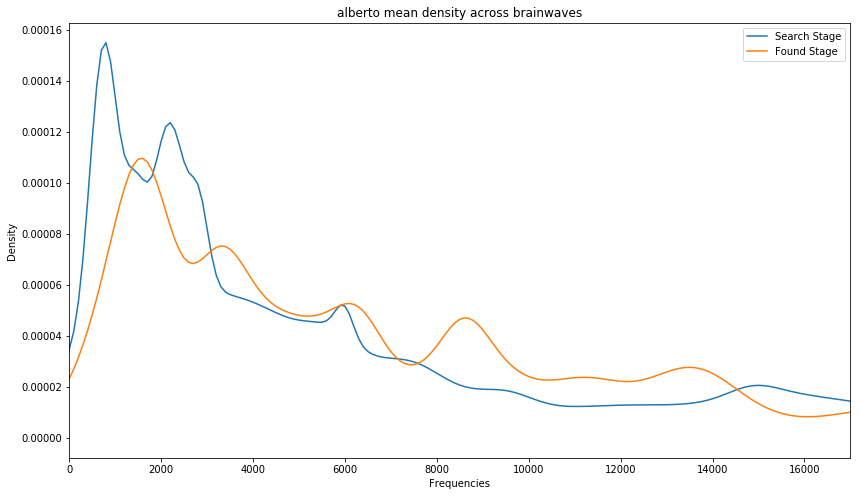

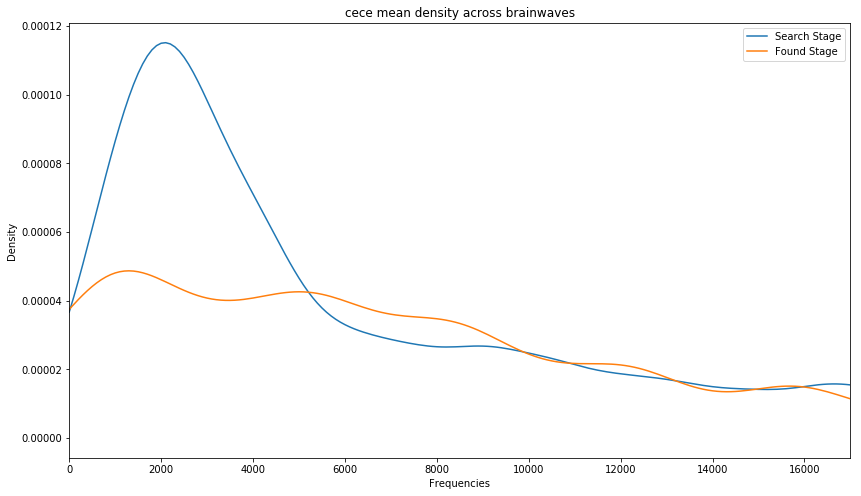

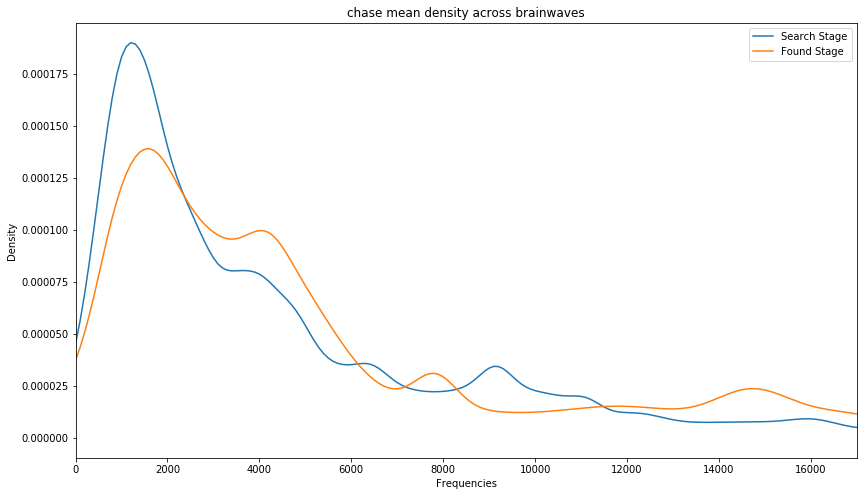

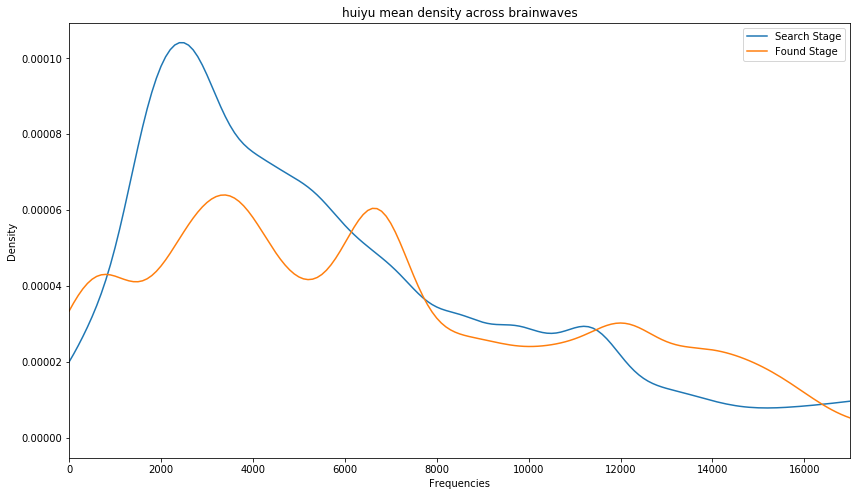

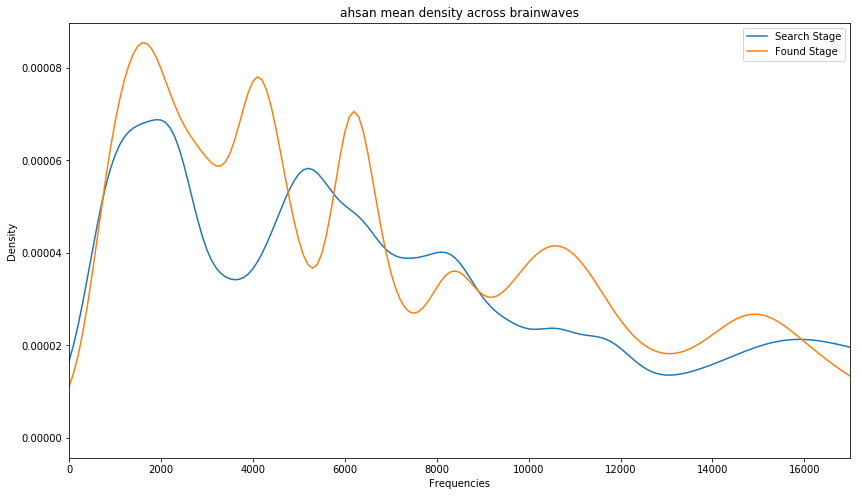

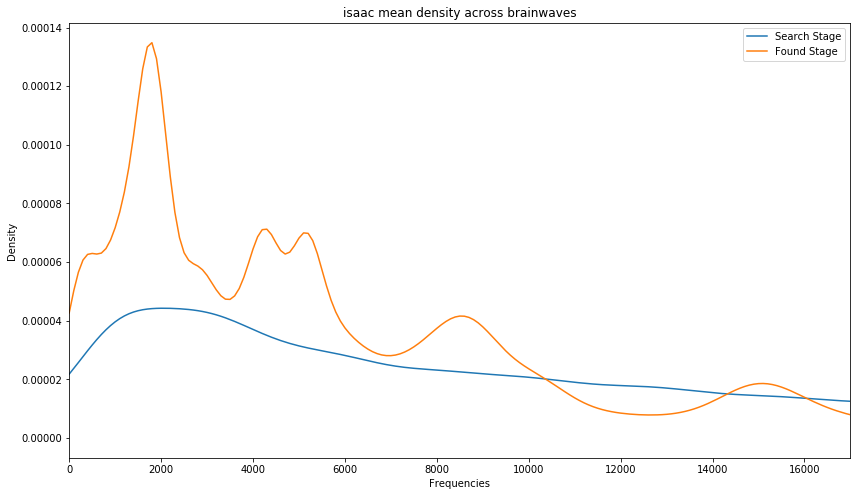

In [24]:
#plotting
if((len(found_means)) != (len(search_means))):
    print("ERROR")

for i in range(0,len(found_means)):
    plot_avg(mean_vectors=[search_means[i],found_means[i]], labels=['Search Stage', 'Found Stage'], title=trial_labels[i])

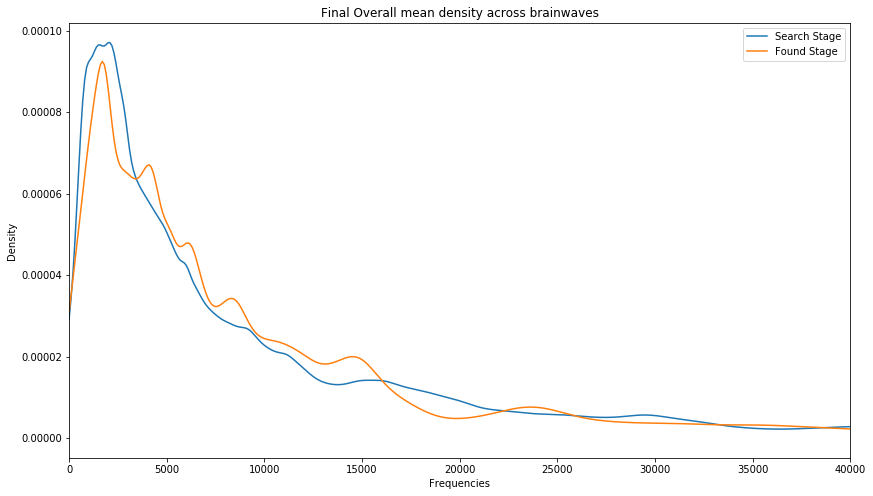

In [25]:
final_search = sum(search_means)/len(search_means)
final_found = sum(found_means)/len(found_means)

plot_avg(mean_vectors=[final_search, final_found], labels=['Search Stage', 'Found Stage'], title='Final Overall', x_max=40000)

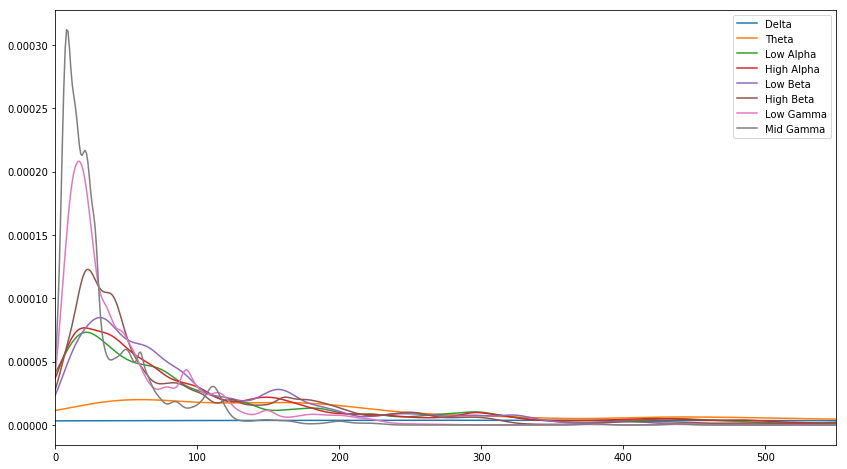

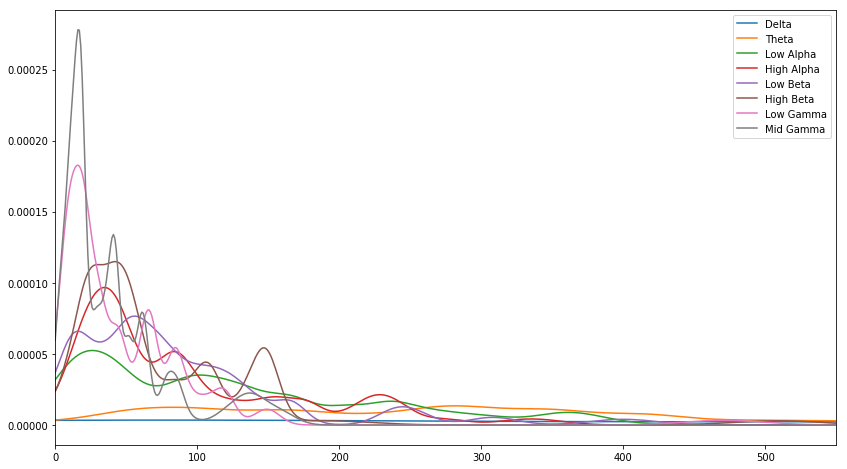

In [26]:
mean_search_den = sum(search_density_mats)/len(search_density_mats)
mean_found_den = sum(found_density_mats)/len(found_density_mats)

search_df = densityframe(mean_search_den)
found_df = densityframe(mean_found_den)

#found_density_df.iloc[:,:-1].plot(figsize=(14,8))

search_df.iloc[:,:-1].plot(figsize=(14,8))
plt.xlim(0,550)
plt.show()

found_df.iloc[:,:-1].plot(figsize=(14,8))
plt.xlim(0,550)
plt.show()

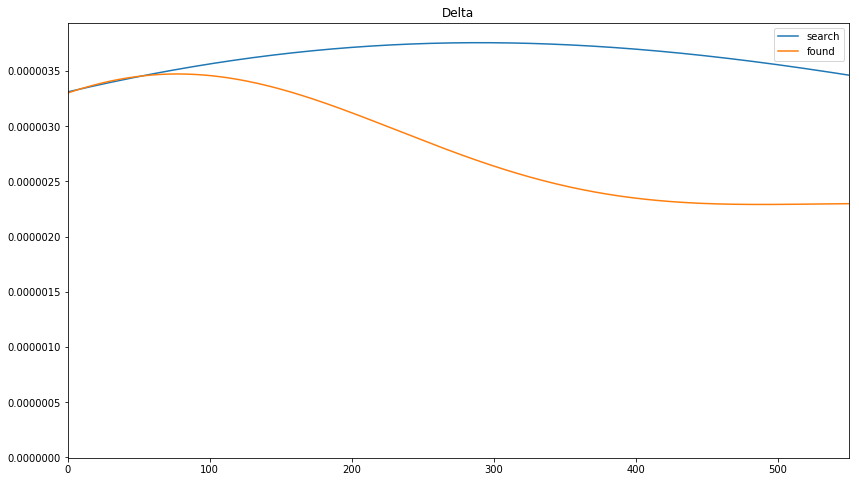

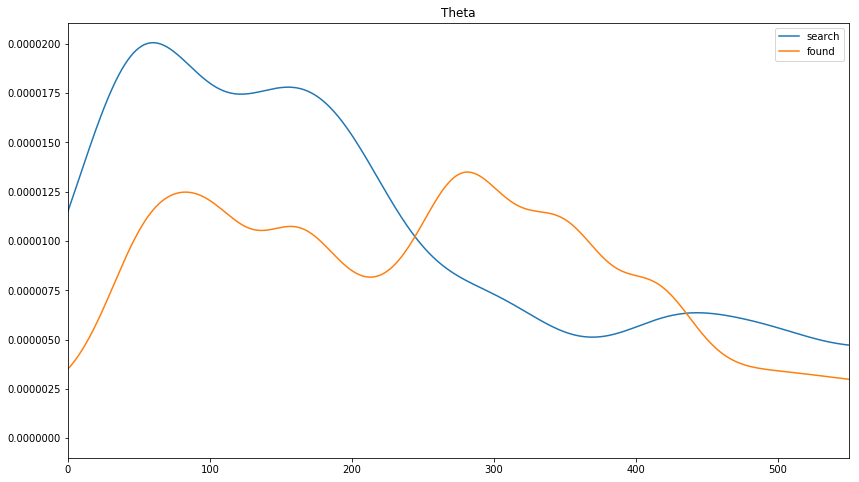

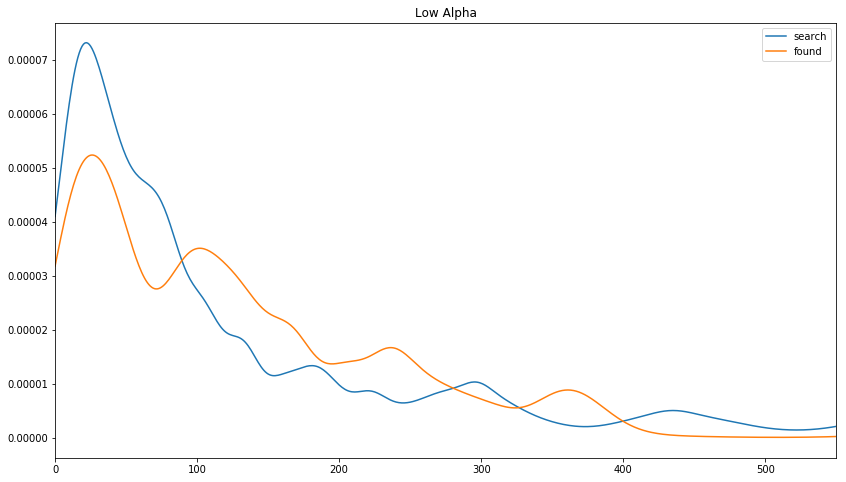

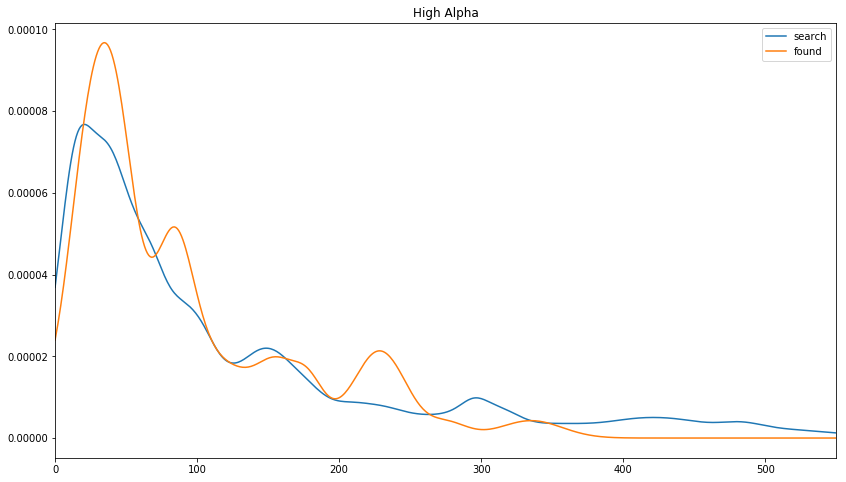

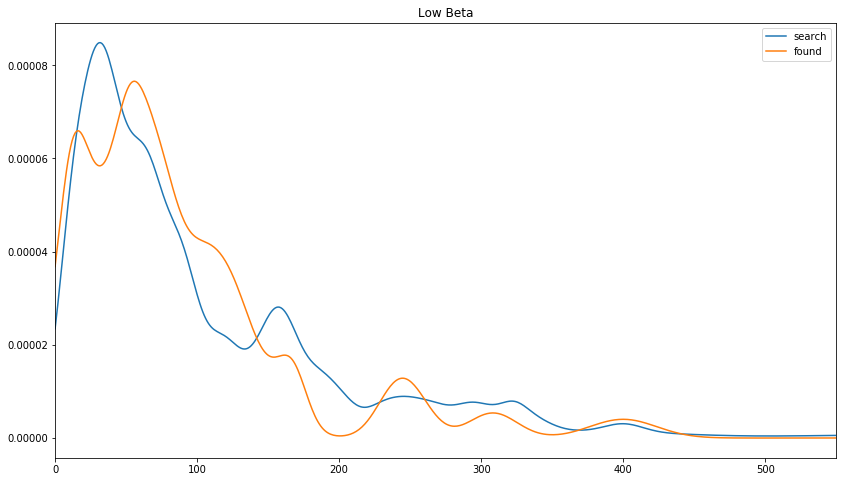

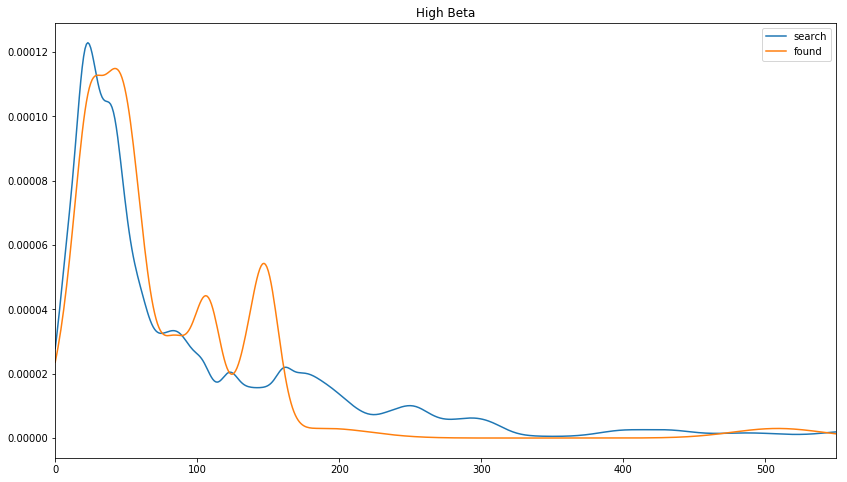

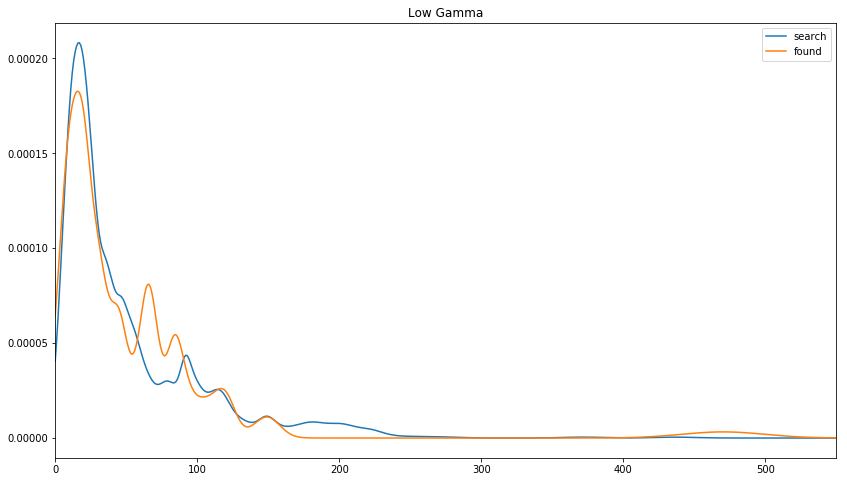

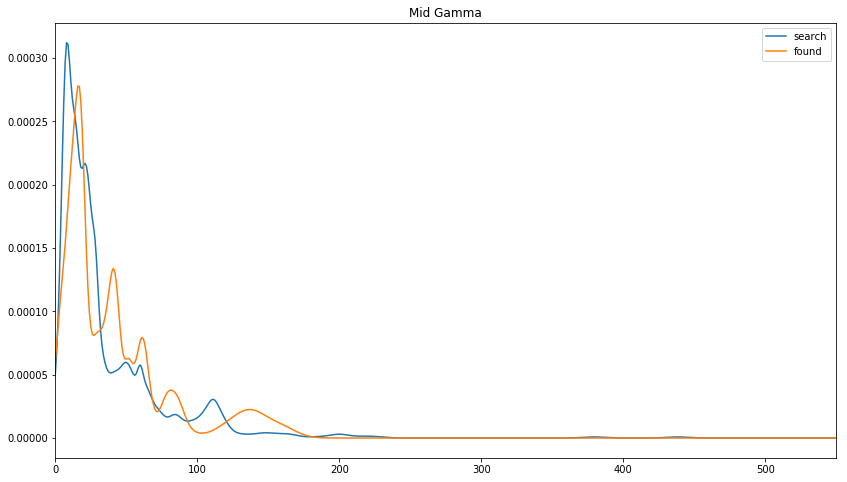

In [27]:
cols = list(search_df.columns)[0:len(list(search_df.columns))-1] 
for c in cols:
    search_df[c].plot(figsize=(14,8), label ='search')
    found_df[c].plot(figsize=(14,8),label ='found')
    plt.title(c)
    plt.legend()
    plt.xlim(0,550)
    plt.show()

In [28]:
len(found_means)

6

Delta


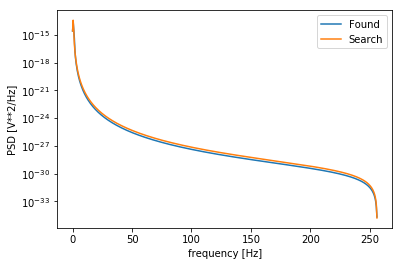

Theta


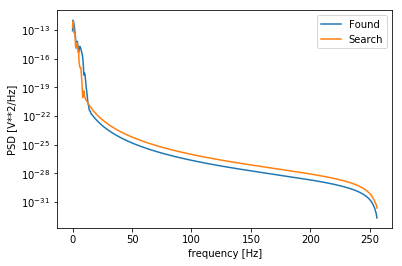

Low Alpha


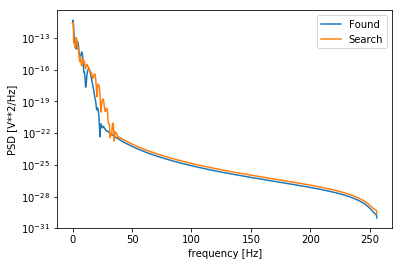

High Alpha


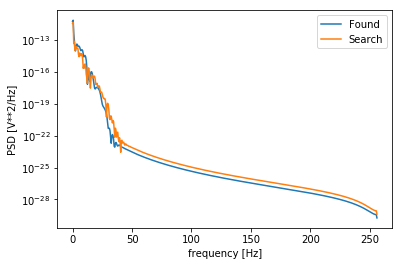

Low Beta


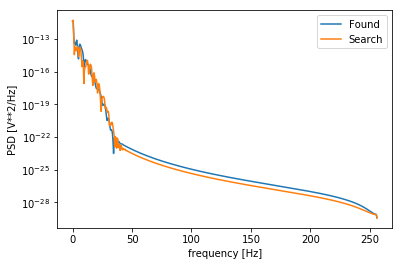

High Beta


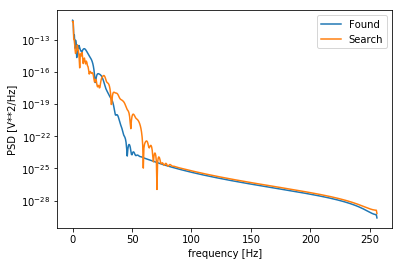

Low Gamma


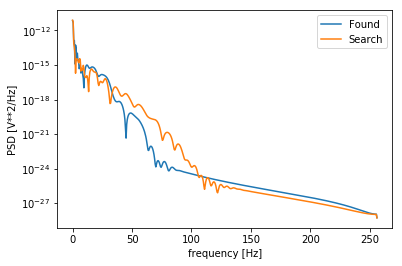

Mid Gamma


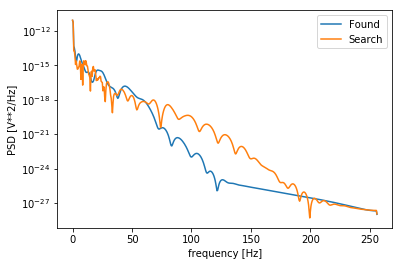

In [29]:
#try Welch windowing

fs = 512
N = len(found_means)

cols = list(found_df.columns)[0:len(list(found_df.columns))-1] 
for c in cols:
    print(c)
    
    f, t = signal.welch(found_df[c], fs, nperseg = 1024)
    f_search, t_search = signal.welch(search_df[c], fs, nperseg = 1024)
    plt.semilogy(f, t, label = 'Found')
    plt.semilogy(f_search,t_search, label = 'Search')
    plt.legend()
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()

### TODO: Right now all of the above runs on find/search from one trial from one person. Need to expand to all trials and then all people

In [30]:
cols = list(search_df.columns)[0:len(list(search_df.columns))-1] 
results = []
for c in cols:
    results.append({c:stats.ttest_rel(search_df[c].values,found_df[c].values, axis =0)})

results

[{'Delta': Ttest_relResult(statistic=11.735121797737802, pvalue=1.5868702443022265e-31)},
 {'Theta': Ttest_relResult(statistic=1.5940597857219814, pvalue=0.11096478790049846)},
 {'Low Alpha': Ttest_relResult(statistic=0.1705022016808097, pvalue=0.8646198027512866)},
 {'High Alpha': Ttest_relResult(statistic=0.13711399635681254, pvalue=0.8909443703974488)},
 {'Low Beta': Ttest_relResult(statistic=1.8289922395789893, pvalue=0.06744046289035709)},
 {'High Beta': Ttest_relResult(statistic=0.12179519041357367, pvalue=0.9030644865104706)},
 {'Low Gamma': Ttest_relResult(statistic=1.0642575866905153, pvalue=0.28724629300174565)},
 {'Mid Gamma': Ttest_relResult(statistic=0.21299322171069307, pvalue=0.8313380393253148)}]

In [31]:
found_df.describe()

,Delta,Theta,Low Alpha,High Alpha,Low Beta,High Beta,Low Gamma,Mid Gamma,True Amplitude
count,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000
mean,8.486857e-07,1.191614e-06,1.239616e-06,1.274694e-06,1.264926e-06,0.000001,0.000001,0.000001,375050.000000
std,8.075798e-07,2.579360e-06,5.603315e-06,7.851135e-06,7.685082e-06,0.000009,0.000011,0.000013,216520.784222
min,2.014253e-07,5.671817e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,100.000000
25%,2.564226e-07,1.868385e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,187575.000000
50%,3.460188e-07,2.302532e-07,4.345387e-194,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,375050.000000
75%,1.388645e-06,5.032588e-07,5.839873e-17,3.704832e-63,8.344155e-162,0.000000,0.000000,0.000000,562525.000000
max,3.473328e-06,1.349850e-05,5.242701e-05,9.672168e-05,7.656694e-05,0.000115,0.000183,0.000278,750000.000000


In [32]:
len(results)

8

In [94]:
def compute_power_spectrum(x_a):
    return np.abs(x_a)**2, np.angle(x_a)
    
def fft(signal_name, signal_1, signal_2, sampling_rate):
    
    fs = 1/sampling_rate
    N_1 = signal_1.size
    N_2 = signal_2.size
    
    y1 = signal_1.values
    yf1 = scipy.fft(y1)
    
    y2 = signal_2.values
    yf2 = scipy.fft(y2)
    
    x1 = scipy.fftpack.fftfreq(yf1.size, fs)
    xf1 = scipy.fftpack.fftfreq(N_1, d = fs)
    
    x2 = scipy.fftpack.fftfreq(yf2.size, fs)
    xf2 = scipy.fftpack.fftfreq(N_2, d = fs)

    fid, ax = plt.subplots()
    ax.plot(x1[:x1.size//2], abs(yf1)[:yf1.size//2], label = 'Search')
    ax.plot(x2[:x2.size//2], abs(yf2)[:yf2.size//2], label='Found')
    plt.xlim(0,2)
    plt.legend()
    plt.title('{} FFT'.format(signal_name))
    plt.xlabel('Frequency');plt.ylabel('Phase')
    plt.show()
    
    return x1, yf1 , x2, yf2
    
    
def plot_power_spectrum(signal_name, signal1, signal2):
    plt.figure(figsize=(20,3))
        
    fs=512
    freqs_search, phasor_search, freqs_found, phasor_found= fft(signal_name,signal1, signal2,fs)

    power_search, phase_search = compute_power_spectrum(phasor_search)
    power_found, phase_found = compute_power_spectrum(phasor_found)
    
    plt.plot(freqs_search, power_search, '.', label = 'Search')
    plt.plot(freqs_found, power_found, '.', label = 'Found')
    
    
    plt.xlim([0,8])
    plt.legend()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (mV^2)')
    #plt.ylim([0,2])
    plt.title('{} power spectrum'.format(signal_name))

<Figure size 1440x216 with 0 Axes>

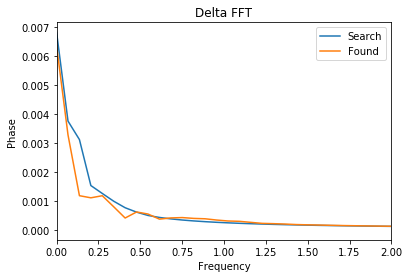

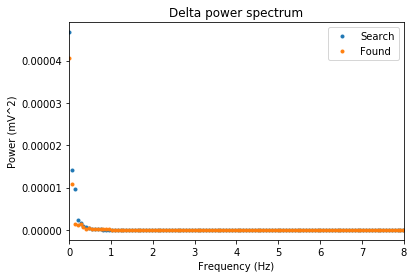

<Figure size 1440x216 with 0 Axes>

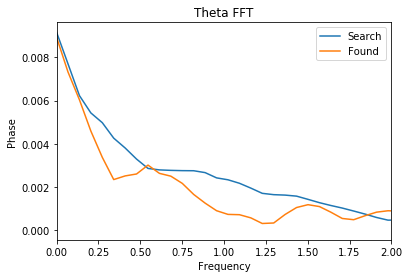

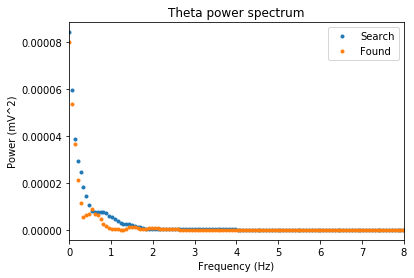

<Figure size 1440x216 with 0 Axes>

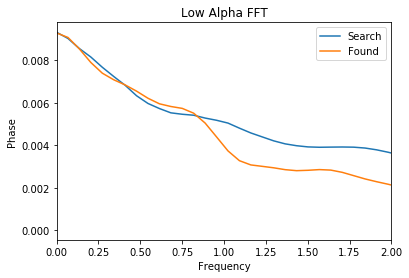

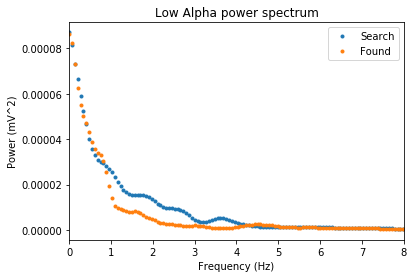

<Figure size 1440x216 with 0 Axes>

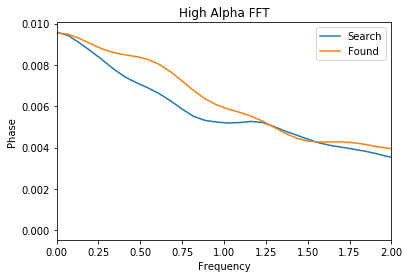

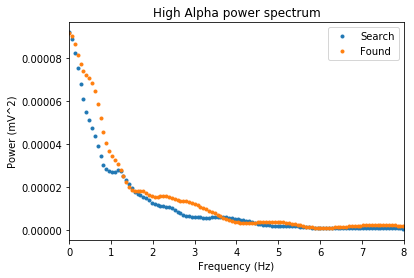

<Figure size 1440x216 with 0 Axes>

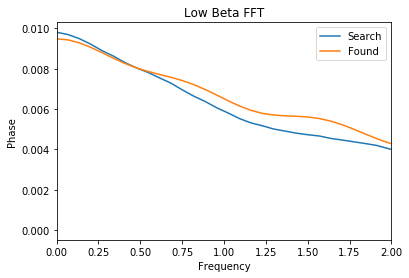

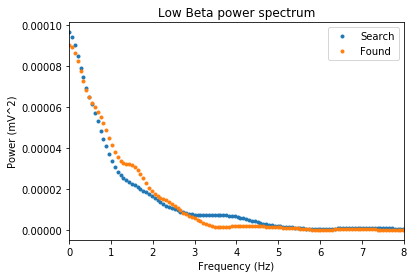

<Figure size 1440x216 with 0 Axes>

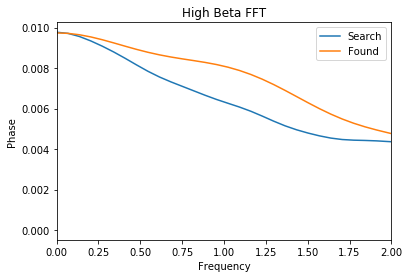

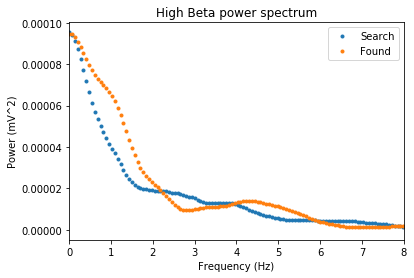

<Figure size 1440x216 with 0 Axes>

In [ ]:
for c in cols: 
    plot_power_spectrum(c, search_df[c], found_df[c])

In [92]:
for c in cols:
    model = sm.OLS(endog = found_df[c], exog = np.arange(7500))
    res = model.fit()
    
    print('{} Model Summary'.format(c))
    print(res.summary())
    print('\n\n\n\n\n')



Delta Model Summary
                            OLS Regression Results                            
Dep. Variable:                  Delta   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     935.7
Date:                Fri, 20 Mar 2020   Prob (F-statistic):          9.21e-194
Time:                        01:21:59   Log-Likelihood:                 92228.
No. Observations:                7500   AIC:                        -1.845e+05
Df Residuals:                    7499   BIC:                        -1.844e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9.012e-11   2.95e-12

In [93]:
for c in cols:
    model = sm.OLS(endog = search_df[c], exog = np.arange(7500))
    res = model.fit()
    
    print('{} Model Summary'.format(c))
    print(res.summary())
    print('\n\n\n\n\n')

Delta Model Summary
                            OLS Regression Results                            
Dep. Variable:                  Delta   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     573.6
Date:                Fri, 20 Mar 2020   Prob (F-statistic):          3.33e-122
Time:                        01:22:00   Log-Likelihood:                 90732.
No. Observations:                7500   AIC:                        -1.815e+05
Df Residuals:                    7499   BIC:                        -1.815e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8.613e-11    3.6e-12